# Lab 3 Reduction and Analysis

# Imports

In [234]:
# imports 
from astropy.io import fits
import lmfit
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from scipy.signal import find_peaks, medfilt
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import re
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate
from scipy.ndimage import median_filter

%matplotlib widget  

# Filepaths

In [192]:
# define directories with data
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'data')
wl_cals_dir = os.path.join(data_dir, 'wl_cals')
solar_dir = os.path.join(data_dir, 'solar')
master_cals_dir = os.path.join(data_dir, 'master_cals')
p_cygni_dir = os.path.join(data_dir, 'p_cygni')

# master calibration data filepaths
master_bias_path = os.path.join(master_cals_dir, 'master_bias.fits')
master_dark_path = os.path.join(master_cals_dir, 'master_dark.fits')
master_flat_path = os.path.join(master_cals_dir, 'master_flat.fits')

# calibration data filepaths
he_cal_fname = os.path.join(wl_cals_dir, 'he_cal_1-5s_exp4.fit')
ne_ar_init_fname = os.path.join(wl_cals_dir, 'ne_ar_cal_15s_exp3.fit')

# solar spectrum data
solar_1 = os.path.join(solar_dir, 'twilight_200s_exp1.fit')
solar_2 = os.path.join(solar_dir, 'twilight_400s_exp2.fit')

# p cygni data
p_cyg_fname_1 = os.path.join(p_cygni_dir, 'p_cyg_300s_exp23.fit')
p_cyg_fname_2 = os.path.join(p_cygni_dir, 'p_cyg_180s_exp22.fit')
kap_cas_fname = os.path.join(p_cygni_dir, 'kap_cas_180s_exp11.fit')

# Important Lines/Series:

In [184]:
balmer = [6562.8, 4861.33, 4340.47, 4101.74, 3970.07, 3889.05, 3835.38]
wavelengths_He = np.array([3880,4470,5010,5880,6680,7060,7280])
fraunhofer = np.array([3934, 3968, 4308, 4861, 5270, 5890, 5896, 6563, 6875.5, 7607.5])
ne_ar_wls = np.array([5857.49403984, 6566.7529648,  6966.65427355, 7067.76139689, 7380.13713618,
                      7499.35299803, 7629.13229069, 7716.6578601, 8098.45043039])

# Functions

In [217]:
# Functions from Dillon's pipeline

def load_image(fname):
    """Read FITS image and return numpy array + header."""
    with fits.open(fname) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header
    return data, header

def calibrate_science_frame(path, master_bias, master_dark, master_flat):
    sci, hdr = load_image(path)
    sci_bias_sub = sci - master_bias
    exptime = hdr.get("EXPTIME", hdr.get("TELAPSE", 0))
    scaled_dark = master_dark * (exptime / 30.0)   # 30s dark
    sci_dark_sub = sci_bias_sub - scaled_dark
    safe_flat = np.where(master_flat == 0, 1, master_flat)
    sci_calibrated = sci_dark_sub / safe_flat
    return sci_calibrated, hdr

def crop_spectrum_region(image, center_row=3100, height=100, plots=True):
    half = height // 2
    y_min = max(center_row - half, 0)
    y_max = min(center_row + half, image.shape[0])
    crop = image[y_min:y_max, :]
    plt.figure(figsize=(10,4))
    plt.imshow(crop, cmap="viridis", norm=LogNorm(), origin="lower")
    return crop

def plot_spectral_profile(cropped_image):
    spectrum = np.sum(cropped_image, axis=0)
    xpix = np.arange(len(spectrum))

    plt.figure(figsize=(8, 4))
    plt.plot(xpix, spectrum, color='black', linewidth=1)
    plt.xlim([3000, 8000])
    plt.xlabel("Pixel index")
    plt.ylabel("Integrated counts")
    plt.title("Extracted 1D Spectral Profile")
    plt.tight_layout()
    plt.show()

    return spectrum

def detect_trace_center(crop):
    row_sums = np.sum(crop, axis=1)
    y = np.arange(len(row_sums))

    def gauss(x, A, mu, sigma, C):
        return A * np.exp(-(x - mu)**2/(2*sigma**2)) + C

    A0 = row_sums.max() - row_sums.min()
    mu0 = np.argmax(row_sums)
    sigma0 = 5
    C0 = row_sums.min()

    popt, _ = curve_fit(gauss, y, row_sums, p0=[A0, mu0, sigma0, C0])
    mu, sigma = popt[1], abs(popt[2])

    plt.figure(figsize=(10,4))
    plt.imshow(crop, cmap="viridis", norm=LogNorm(), origin="lower")
    plt.axhline(mu, alpha=.7, color="red", linestyle="--", linewidth=2)
    plt.show()

    return mu, sigma

def isolate_spectrum(crop, y_trace, sigma):
    ny, nx = crop.shape
    # tune these values if you want
    signal_sigma = 2.8
    bg_min_sigma = signal_sigma + 1
    bg_max_sigma = bg_min_sigma + signal_sigma
    y1 = int(max(0, y_trace - signal_sigma*sigma))
    y2 = int(min(ny, y_trace + signal_sigma*sigma))
    b1s = int(max(0, y_trace - bg_max_sigma*sigma))
    b1e = int(max(0, y_trace - bg_min_sigma*sigma))
    b2s = int(min(ny, y_trace + bg_min_sigma*sigma))
    b2e = int(min(ny, y_trace + bg_max_sigma*sigma))

    sky = []
    if b1e > b1s: sky.append(crop[b1s:b1e, :])
    if b2e > b2s: sky.append(crop[b2s:b2e, :])
    sky = np.concatenate(sky, axis=0)

    sky_level = np.median(sky, axis=0)

    spec = crop[y1:y2, :] - sky_level

    return spec


def inspect_trace_fit(spec_strip, mu, sigma):
    row_sums = np.sum(spec_strip, axis=1)
    y = np.arange(len(row_sums))

    A = row_sums.max()
    C = np.median(row_sums)
    gauss = A * np.exp(-(y - mu)**2 / (2*sigma**2)) + C

    signal_sigma = 2.8
    bg_min_sigma = signal_sigma + 1
    bg_max_sigma = bg_min_sigma + signal_sigma

    
    plt.figure(figsize=(8,4))
    plt.axvspan(mu - signal_sigma*sigma, mu + signal_sigma*sigma, color='lightgreen', alpha=0.4)

    plt.axvspan(mu - bg_max_sigma*sigma, mu - bg_min_sigma*sigma, color='orange', alpha=0.4)
    plt.axvspan(mu + bg_min_sigma*sigma, mu + bg_max_sigma*sigma, color='orange', alpha=0.4)

    plt.plot(y, row_sums, 'k-', lw=1)
    plt.plot(y, gauss, 'r--', lw=2)

    plt.xlabel("Row index in spec_strip")
    plt.ylabel("Sum of counts")
    plt.title(fr"Trace Gaussian Fit: $\mu$={mu:.2f}, $\sigma$={sigma:.2f}")
    plt.tight_layout()
    plt.show()

def find_and_plot_peaks(spectrum, n=8, reference_pixels=None):
    spec = spectrum.astype(float)
    smooth = gaussian_filter1d(spec, sigma=2)
    peaks, props = find_peaks(
        smooth,
        prominence=0.05*np.max(smooth),
        width=2,               
        distance=20)

    if len(peaks) < n:
        peaks, props = find_peaks(
            smooth,
            prominence=0.03*np.max(smooth),
            width=1,
            distance=10)

    heights = smooth[peaks]
    order = np.argsort(heights)[::-1]
    top = peaks[order[:n]]

    top = np.sort(top)

    plt.figure(figsize=(8,4))
    plt.plot(spec, 'gray', lw=1, alpha=0.5)
    plt.plot(smooth, 'k-', lw=1)
    for p in top:
        plt.axvline(p, color='blue', alpha=0.4)
    if reference_pixels is not None:
        for r in reference_pixels:
            plt.axvline(r, color='red', linestyle='--', alpha=0.6)

    plt.xlabel("Pixel index")
    plt.ylabel("Counts")
    plt.title("Peak Detection")
    plt.tight_layout()
    plt.show()

    return top.tolist()

def fit_linear_wavelength(lines_pix, lines_ref):
    pix = np.array(lines_pix, dtype=float)
    lam = np.array(lines_ref, dtype=float)
    a, b = np.polyfit(pix, lam, 1)
    lam_fit = a * pix + b
    ss_res = np.sum((lam - lam_fit)**2)
    ss_tot = np.sum((lam - np.mean(lam))**2)
    r2 = 1 - ss_res/ss_tot

    plt.figure(figsize=(7,5))
    plt.scatter(pix, lam, color='blue', label='He line matches')
    
    xline = np.linspace(min(pix), max(pix), 200)
    yline = a * xline + b
    plt.plot(xline, yline, 'r-', label=f'Fit: λ = {a:.4f}·p + {b:.2f}')

    plt.xlabel("Pixel position")
    plt.ylabel("Wavelength (Å)")
    plt.title(f"Linear Wavelength Fit   (R² = {r2:.5f})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    return a, b, r2

def apply_linear_wavesolution(spectrum, a, b, shift=0):
    n = len(spectrum)
    pixels = np.arange(n, dtype=float)
    wavelengths = a*(pixels+shift) + b
    return wavelengths

def plot_spectrum_with_refs(wavelengths, spectrum, reference_wavelengths=None, xlims=[0,11000]):
    plt.figure(figsize=(12,4))
    plt.plot(wavelengths, spectrum, 'k-', lw=1)

    if reference_wavelengths is not None:
        for w in reference_wavelengths:
            plt.axvline(w, color='red', linestyle='--', alpha=0.6)
    plt.xlim(xlims)
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Counts")
    plt.title("Spectrum with Reference Lines")
    plt.tight_layout()
    plt.show()

def measure_pixel_shift(ref_spec, new_spec, max_shift=200):
    r = ref_spec - np.median(ref_spec)
    s = new_spec - np.median(new_spec)

    corr = correlate(s, r, mode='full')
    lags = np.arange(-len(s)+1, len(r))

    mask = (lags >= -max_shift) & (lags <= max_shift)
    corr = corr[mask]
    lags = lags[mask]

    best_lag = lags[np.argmax(corr)]
    return best_lag

import numpy as np
from scipy.signal import correlate

def measure_subpixel_shift(ref, new, max_shift=200):
    r = ref - np.median(ref)
    s = new - np.median(new)

    corr = correlate(s, r, mode='full')
    lags = np.arange(-len(s)+1, len(r))

    mask = (lags >= -max_shift) & (lags <= max_shift)
    corr = corr[mask]
    lags = lags[mask]
    k = np.argmax(corr)
    peak_lag = lags[k]

    if 0 < k < len(corr)-1:
        Ckm1 = corr[k-1]
        Ck   = corr[k]
        Ckp1 = corr[k+1]

        denom = (Ckm1 - 2*Ck + Ckp1)
        if denom != 0:
            delta = 0.5 * (Ckm1 - Ckp1) / denom
        else:
            delta = 0.0
    else:
        delta = 0.0

    return peak_lag + delta

def crop_spectrum(wave, flux, wmin, wmax):
    mask = (wave >= wmin) & (wave <= wmax)
    return wave[mask], flux[mask]

def flatten_with_median(wave, flux, width=301):
    cont = median_filter(flux, size=width)
    flat = flux / cont

    plt.figure(figsize=(12,4))
    plt.plot(wave, flux, 'k-', lw=1)
    plt.plot(wave, cont, 'r-', lw=2)
    plt.title("Median-Filter Continuum")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,3))
    plt.plot(wave, flat, 'k-', lw=1)
    plt.axhline(1.0, color='r', ls='--')
    plt.title("Flattened Spectrum (Median)")
    plt.tight_layout()
    plt.show()

    return wave, flat, cont

def flatten_spectrum(wave, flux, deg=5):
    mask = np.isfinite(wave) & np.isfinite(flux) & (flux > 0)
    w = wave[mask]
    f = flux[mask]

    coeffs = np.polyfit(w, f, deg)
    cont = np.polyval(coeffs, w)

    flat = f / cont

    plt.figure(figsize=(12,4))
    plt.plot(w, f, 'k-', lw=1)
    plt.plot(w, cont, 'r-', lw=2)
    plt.title("Continuum Fit")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,3))
    plt.plot(w, flat, 'k-', lw=1)
    plt.axhline(1.0, color='r', ls='--')
    plt.title("Flattened Spectrum")
    plt.tight_layout()
    plt.show()

    return w, flat, coeffs

def flatten_spectra(wl, spec, smooth_width=101, poly_deg=5):

    spec_smooth = median_filter(spec, smooth_width)
    ratio = spec / spec_smooth

    mask = (ratio > 0.99) & (wl > 4000) & (wl < 8000)
    wl_masked = wl[mask]
    spec_masked = spec[mask]

    coeffs = np.polyfit(wl_masked, spec_masked, poly_deg)
    continuum_fit = np.polyval(coeffs, wl)
    spec_normed = spec / continuum_fit

    plt.figure(figsize=(12,4))
    plt.plot(wl, ratio, 'k-', lw=1)
    plt.axhline(1.0, color='r', ls='--')
    plt.xlim(4000, 8000)
    plt.title("Spectrum / Median Smooth")
    plt.tight_layout()
    plt.ylim([.9, 1.1])
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(wl, spec, 'gray', lw=1, label='Original Spectrum')
    plt.plot(wl_masked, spec_masked, 'b.', alpha=0.4, label='Continuum Points')
    plt.plot(wl, continuum_fit, 'r-', lw=2, label='Polynomial Fit')
    plt.xlim(4000, 8000)
    plt.ylim(0, np.nanmax(spec_masked)*1.1)
    plt.title("Continuum Fit")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,4))
    plt.plot(wl, spec_normed, 'k-', lw=1)
    plt.axhline(1.0, color='r', ls='--')
    plt.xlim(4000, 8000)
    plt.ylim(0, 1.1)
    plt.title("Normalized Spectrum")
    plt.tight_layout()
    plt.show()

    return wl, spec_normed, continuum_fit

In [242]:
# My functions
def linear_fit(x, y):
    """
    Perform an analytical solution to fit y = mx + b.

    Parameters:
    x (array-like): Independent variable.
    y (array-like): Dependent variable.

    Returns:
    tuple: Slope (m) and intercept (b).
    """
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xx = np.sum(x * x)
    sum_xy = np.sum(x * y)

    m = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
    b = (sum_y - m * sum_x) / n

    return m, b


def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + offset


def measure_resolution(pixels,flux,dispersion_ang_per_pix,lambda_line,line_center_guess,fit_half_width_pix=10,):
    """
    Measure spectral resolution from an isolated line.

    Parameters
    ----------
    pixels : 1D array
        Pixel coordinate array (e.g. np.arange(n_pix)).
    flux : 1D array
        Flux values for the 1D extracted spectrum.
    dispersion_ang_per_pix : float
        Dispersion in Angstroms per pixel.
    lambda_line : float
        Wavelength (Angstrom) of the line you're fitting.
    line_center_guess : float
        Initial guess for the line center in PIXELS
        (e.g. np.argmax(flux) near the line).
    fit_half_width_pix : int, optional
        Half-width (in pixels) of the fitting window around line_center_guess.

    Returns
    -------
    results : dict
        {
            "mu_pix": line center in pixels,
            "sigma_pix": sigma of Gaussian in pixels,
            "fwhm_pix": FWHM in pixels,
            "fwhm_ang": FWHM in Angstroms,
            "R": resolving power at lambda_line
        }
    """
    # Select a window around the line
    mask = (
        (pixels >= line_center_guess - fit_half_width_pix)
        & (pixels <= line_center_guess + fit_half_width_pix)
    )
    x = pixels[mask]
    y = flux[mask]

    # Initial parameter guesses for [amp, mu, sigma, offset]
    amp_guess = y.max() - np.median(y)
    mu_guess = line_center_guess
    sigma_guess = fit_half_width_pix / 3.0  # rough
    offset_guess = np.median(y)

    p0 = [amp_guess, mu_guess, sigma_guess, offset_guess]

    # Fit Gaussian
    popt, pcov = curve_fit(gaussian, x, y, p0=p0)
    amp_fit, mu_fit, sigma_fit, offset_fit = popt

    # FWHM in pixels for a Gaussian: FWHM = 2*sqrt(2*ln(2))*sigma
    fwhm_pix = 2.0 * np.sqrt(2.0 * np.log(2.0)) * sigma_fit

    # Convert to Angstroms
    fwhm_ang = fwhm_pix * dispersion_ang_per_pix

    # Resolving power
    R = lambda_line / fwhm_ang

    return {
        "mu_pix": mu_fit,
        "sigma_pix": sigma_fit,
        "fwhm_pix": fwhm_pix,
        "fwhm_ang": fwhm_ang,
        "R": R,
    }

def plot_basic_spec(fname, im, title="Spectrum Inspection", vmin=0, vmax=1000, xmin=3500, xmax=8000, ymin=1000, ymax=2000):
    im = fits.getdata(fname)[2000:4000, :]
    plt.close('all')
    plt.figure(figsize=(8,6) ,dpi=100)
    plt.imshow(im, origin='lower', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    plt.show()

def extract_1d_spec(im, y_min=1000, y_max=2000):
    # Extract 1D spectrum from NeAr lamp image
    ny, nx = im.shape

    spec_1d = np.median(im[y_min:y_max, :], axis=0)
    x_pix = np.arange(nx)
    return x_pix, spec_1d

def my_find_peaks(spec_1d, prominence=1000, distance=10, num_peaks=10):
    # Identify strongest line positions:
    peaks, props = find_peaks(spec_1d, prominence=prominence, distance=distance)

    # keep num_peaks strongest
    order = np.argsort(props['prominences'])[::-1]
    strong_peaks = peaks[order[:num_peaks]]

    # sort the peaks in increasing pixel order
    sorted_indices = np.argsort(strong_peaks)
    sorted_peaks = strong_peaks[sorted_indices]

    return sorted_peaks, sorted_indices

def plot_spec_and_peaks(x_pix, spec_1d, strong_peaks_idx=None, title="1D Spectrum and Strongest Lines", xmin=4500, xmax=7000,
                         xlabel="x [pixels]", ylabel="Counts", plot_reflines=None, ymin=0, ymax=None):
    plt.figure(dpi=150)
    if plot_reflines is not None:
        for rl in plot_reflines:
            plt.axvline(rl, color='red', linestyle='--', alpha=0.6)
    plt.plot(x_pix, spec_1d, color='black', lw=1)
    if strong_peaks_idx is not None:
        plt.plot(x_pix[strong_peaks_idx], spec_1d[strong_peaks_idx], "x", ms=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([xmin, xmax])
    if ymax is not None:
        plt.ylim([ymin, ymax])
    plt.grid(alpha=0.3)
    plt.show()

def unpack_fits(fname):
    im = fits.getdata(fname)[2000:4000, :]
    return im

import numpy as np
from scipy.signal import medfilt

def continuum_running_median(wave,flux,width,unit="angstrom",dispersion=None):
    wave = np.asarray(wave)
    flux = np.asarray(flux)

    if unit == "pixels":
        width_samples = int(round(width))
    elif unit == "angstrom":
        if dispersion is None:
            dw = np.median(np.diff(wave)) # estimate dispersion from wavelength array
        else:
            dw = dispersion
        width_samples = int(round(width / dw))
    else:
        raise ValueError("unit must be 'angstrom' or 'pixels'")

    if width_samples < 3:
        width_samples = 3
    if width_samples % 2 == 0:
        width_samples += 1  # medfilt wants odd size

    continuum = medfilt(flux, kernel_size=width_samples)

    cont_safe = np.where(continuum == 0, 1.0, continuum)
    flux_norm = flux / cont_safe

    return continuum, flux_norm

# 0) Unpack master cal frames

In [15]:
# load the FITS data directly into variables named master_bias, etc.
with fits.open(master_bias_path) as hdul:
    master_bias = hdul[0].data.astype(float)

with fits.open(master_dark_path) as hdul:
    master_dark = hdul[0].data.astype(float)

with fits.open(master_flat_path) as hdul:
    master_flat = hdul[0].data.astype(float)

print(master_bias.shape, master_dark.shape, master_flat.shape)

flat_norm = master_flat / np.median(master_flat)

(6388, 9576) (6388, 9576) (6388, 9576)


# 1) Spectrograph Parameters
From calibration lamp exposure

## Inspect arc lamp spectra

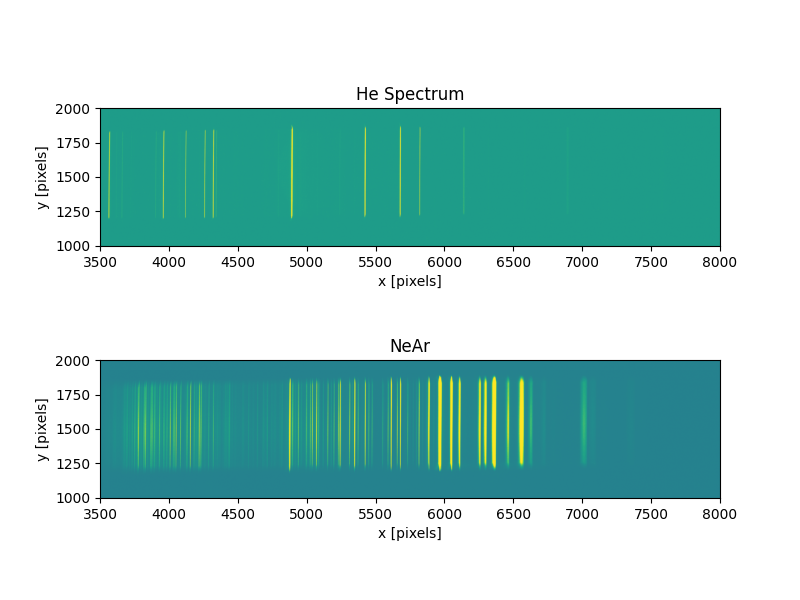

In [16]:
imHe = fits.getdata(he_cal_fname)[2000:4000, :]
imNeAr = fits.getdata(ne_ar_init_fname)[2000:4000, :]
plt.close('all')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
ax1.imshow(imHe, origin='lower', vmin=0, vmax=800)
ax1.set_title("He Spectrum")
ax2.imshow(imNeAr, origin='lower', vmin=0, vmax=1000)
ax2.set_title("NeAr")

for ax in [ax1, ax2]:
    ax.set_xlim([3500, 8000])
    ax.set_ylim([1000, 2000])
    ax.set_xlabel('x [pixels]')
    ax.set_ylabel('y [pixels]')

## Extract 1D spectra

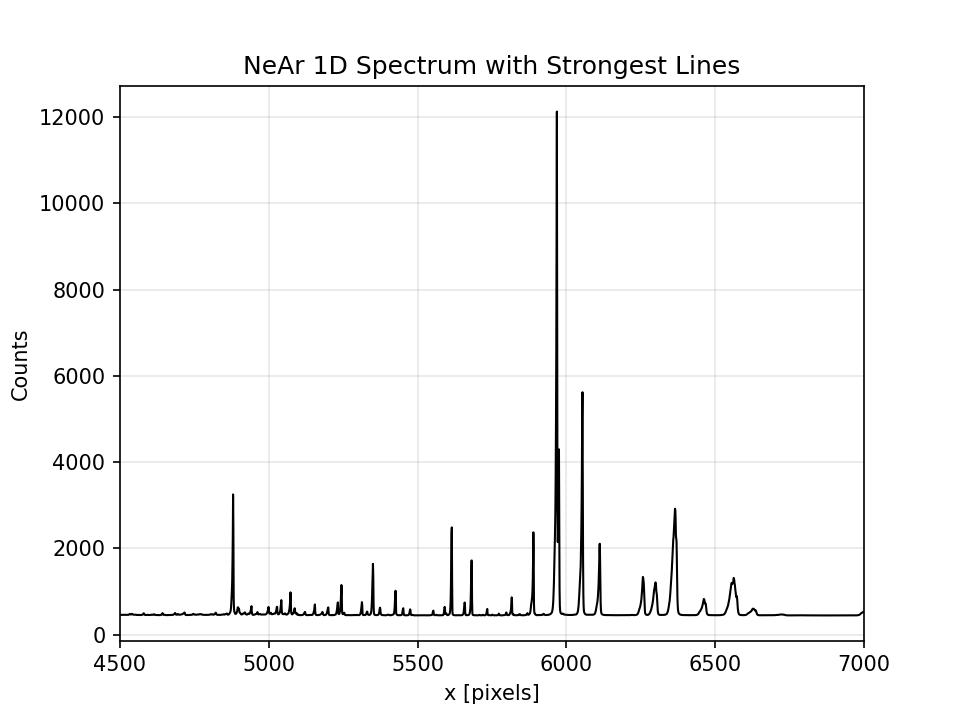

In [172]:
xpix, spec_1d = extract_1d_spec(imNeAr, y_min=1000, y_max=2000)
strong_peaks, strong_peaks_idx = my_find_peaks(spec_1d, prominence=1000, distance=10, num_peaks=10)
plot_spec_and_peaks(xpix, spec_1d, strong_peaks_idx=strong_peaks_idx, title="NeAr 1D Spectrum with Strongest Lines", xmin=4500, xmax=7000)

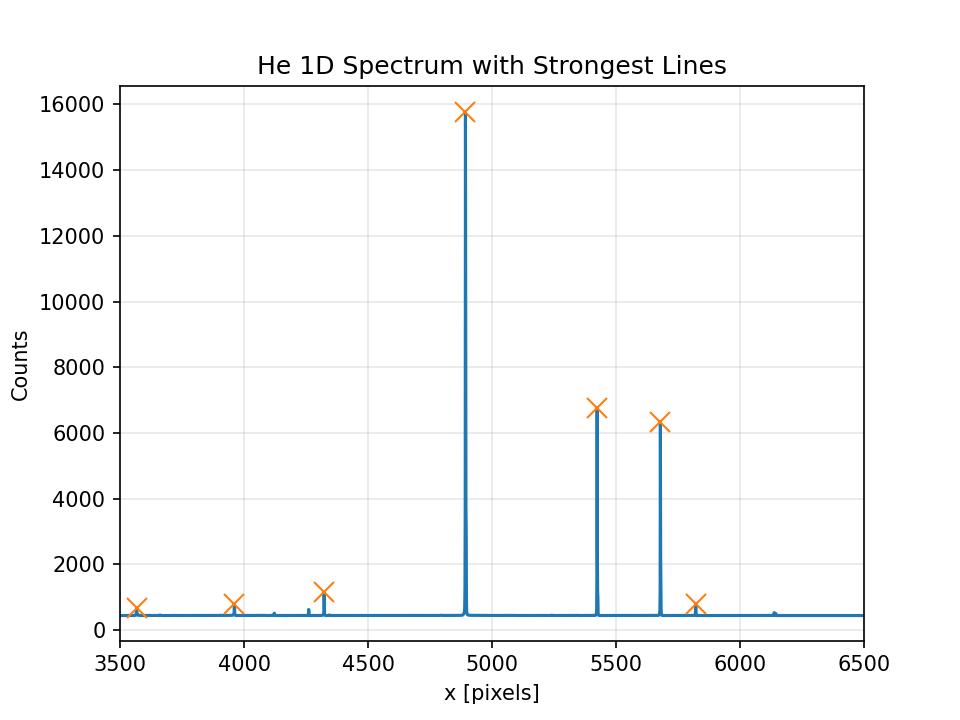

In [18]:
xpix_He, spec_1d_He = extract_1d_spec(imHe, y_min=1000, y_max=2000)
strong_peaks_He, strong_peaks_He_idx = my_find_peaks(spec_1d_He, prominence=200, distance=5, num_peaks=10)
plot_spec_and_peaks(xpix_He, spec_1d_He, strong_peaks=strong_peaks_He, title="He 1D Spectrum with Strongest Lines",
                     xmin=3500, xmax=6500)

## Get wavelength solution

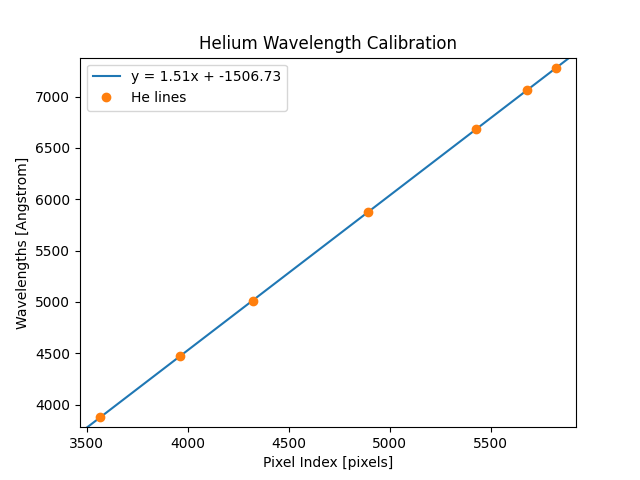

In [168]:
# sort the peaks in increasing pixel order
sorted_indices_He = np.argsort(strong_peaks_He)
sorted_peaks_He = strong_peaks_He[sorted_indices_He]

wavelengths_He = np.array([3880,4470,5010,5880,6680,7060,7280])
wl_index_He = np.arange(imHe.shape[1])

m_wavecal_He, b_wavecal_He = linear_fit(sorted_peaks_He, wavelengths_He)
wl = m_wavecal_He * wl_index_He + b_wavecal_He
plt.figure()
plt.plot(wl_index_He, wl, label = 'y = {:.2f}x + {:.2f}'.format(m_wavecal_He, b_wavecal_He))
plt.plot(sorted_peaks_He, wavelengths_He, 'o', label = 'He lines')
plt.xlim([sorted_peaks_He[0]-100, sorted_peaks_He[-1]+100])
plt.ylim([wavelengths_He[0]-100, wavelengths_He[-1]+100])
plt.xlabel('Pixel Index [pixels]')
plt.ylabel('Wavelengths [Angstrom]')
plt.title('Helium Wavelength Calibration')
plt.legend()

In [20]:
# Compute dispersion from He
nx_He = imHe.shape[1]
x_mid = nx_He / 2.0
dispersion_mid_pix = m_wavecal_He # Å/pixel
print(f"Estimated dispersion at x_mid = {x_mid:.1f} pixels: "
      f"{dispersion_mid_pix:.4f} Å/pixel")

# now now convert that to angstroms per mm
pix_size = 0.00376 # mm
dispersion_mid_mm = dispersion_mid_pix / pix_size  # Å/mm
print(f"Estimated dispersion at x_mid = {x_mid:.1f} pixels: "
      f"{dispersion_mid_mm:.4f} Å/mm")

Estimated dispersion at x_mid = 4788.0 pixels: 1.5091 Å/pixel
Estimated dispersion at x_mid = 4788.0 pixels: 401.3462 Å/mm


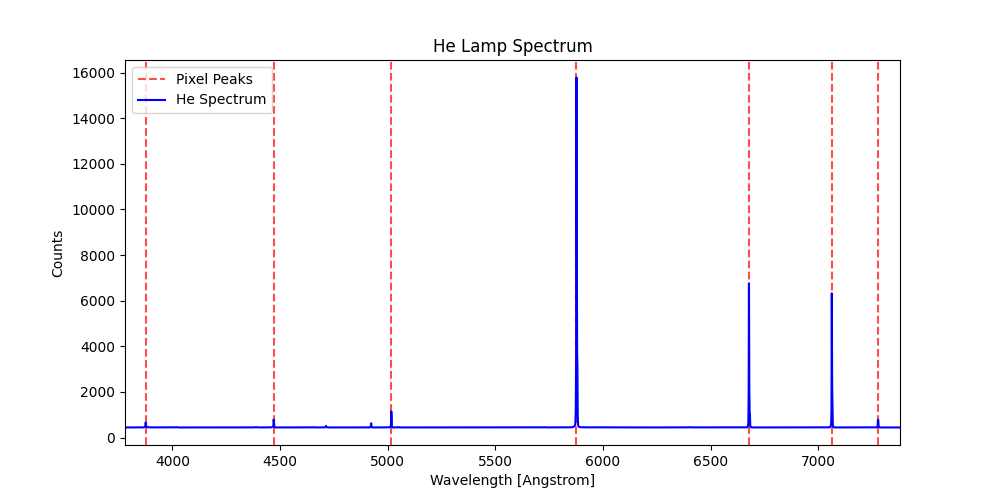

In [169]:
# Replot the He spectra in wavelength space, and confirm alignment
plt.figure(figsize=(10, 5))
for peak in sorted_peaks_He:
    plt.axvline(x=m_wavecal_He * peak + b_wavecal_He, color='red', linestyle='--', alpha=0.7, 
                label ='Pixel Peaks' if peak == sorted_peaks_He[0] else "")
plt.plot(wl, spec_1d_He, label='He Spectrum', color='blue')
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Counts')
plt.title('He Lamp Spectrum')
plt.xlim([wavelengths_He[0]-100, wavelengths_He[-1]+100])
plt.legend()

Detected NeAr line wavelengths (Angstroms): [5857.49403984 6566.7529648  6966.65427355 7067.76139689 7380.13713618
 7499.35299803 7629.13229069 7716.65786015 8098.45043039]


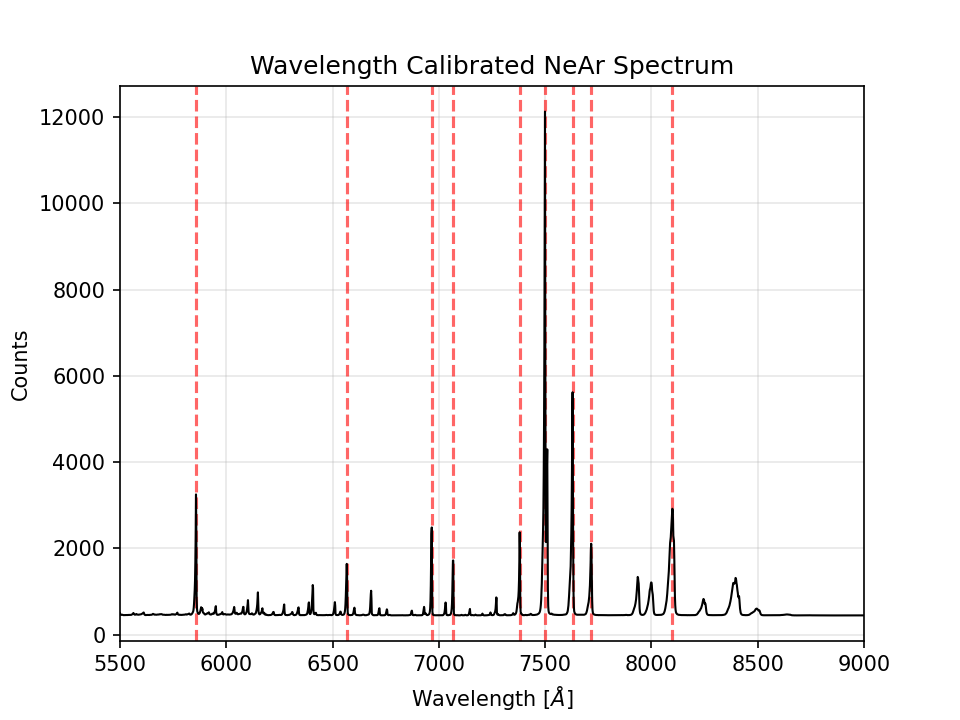

In [183]:
# Use this to see the wavelengths of the NeAr peaks 
wl_near = m_wavecal_He * xpix + b_wavecal_He
# detect peaks in NeAr spectrum, and get associated wavelengths
strong_peaks_NeAr, strong_peaks_NeAr_idx = my_find_peaks(spec_1d, prominence=1000, distance=10, num_peaks=10)
wl_near_peaks = wl_near[strong_peaks_NeAr]
print("Detected NeAr line wavelengths (Angstroms):", wl_near_peaks)
# plot vertical lines at detected NeAr wavelengths
plot_spec_and_peaks(wl_near, spec_1d, title="Wavelength Calibrated NeAr Spectrum",
                     xmin=5500, xmax=9000, xlabel=r"Wavelength [$\AA$]", ylabel="Counts",
                     plot_reflines=wl_near_peaks)

## Determine resolution element + resolving power

In [22]:
pixels = np.arange(nx_He)

# pick a sharp line
line_center_guess = sorted_peaks_He[3]  # pixel index of line near 5880 Å
lambda_line = wavelengths_He[3]  # 5880 Å

resolution_results = measure_resolution(pixels, spec_1d_He, dispersion_mid_pix, lambda_line, line_center_guess)

print(f"Measured resolution at {lambda_line} Å:")
print(f"  Line center (pixels): {resolution_results['mu_pix']:.2f}")
print(f"  Line center (Angstroms): {m_wavecal_He * resolution_results['mu_pix'] + b_wavecal_He:.2f} Å")
print(f"  Sigma (pixels): {resolution_results['sigma_pix']:.2f}")
print(f"  FWHM (pixels): {resolution_results['fwhm_pix']:.2f}")
print(f"  FWHM (Angstroms): {resolution_results['fwhm_ang']:.4f} Å")
print(f"  Resolving Power (R): {resolution_results['R']:.2f}")

Measured resolution at 5880 Å:
  Line center (pixels): 4893.27
  Line center (Angstroms): 5877.51 Å
  Sigma (pixels): 0.74
  FWHM (pixels): 1.73
  FWHM (Angstroms): 2.6128 Å
  Resolving Power (R): 2250.50


# 2) Solar Spectrum

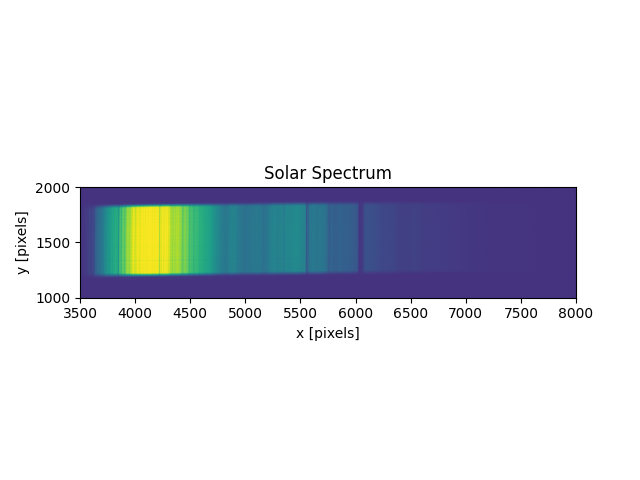

No such comm: 8b1ddd13739b40b3a9db78f44f0f1d5c


In [23]:
# first inspect the spectrum
imSolar = fits.getdata(solar_2)[2000:4000, :]
plot_basic_spec(solar_2, imSolar, title="Solar Spectrum", vmin=0, vmax=3000)

In [36]:
# now extract 1D spectrum
x_pix_solar, spec_solar = extract_1d_spec(imSolar, y_min=1000, y_max=2000)
strong_peaks_solar, strong_peaks_solar_idx = my_find_peaks(spec_solar, prominence=500, distance=10, num_peaks=10)
print("Solar strongest peaks (pixels):", strong_peaks_solar)

Solar strongest peaks (pixels): [1011 4129 4246 5617]


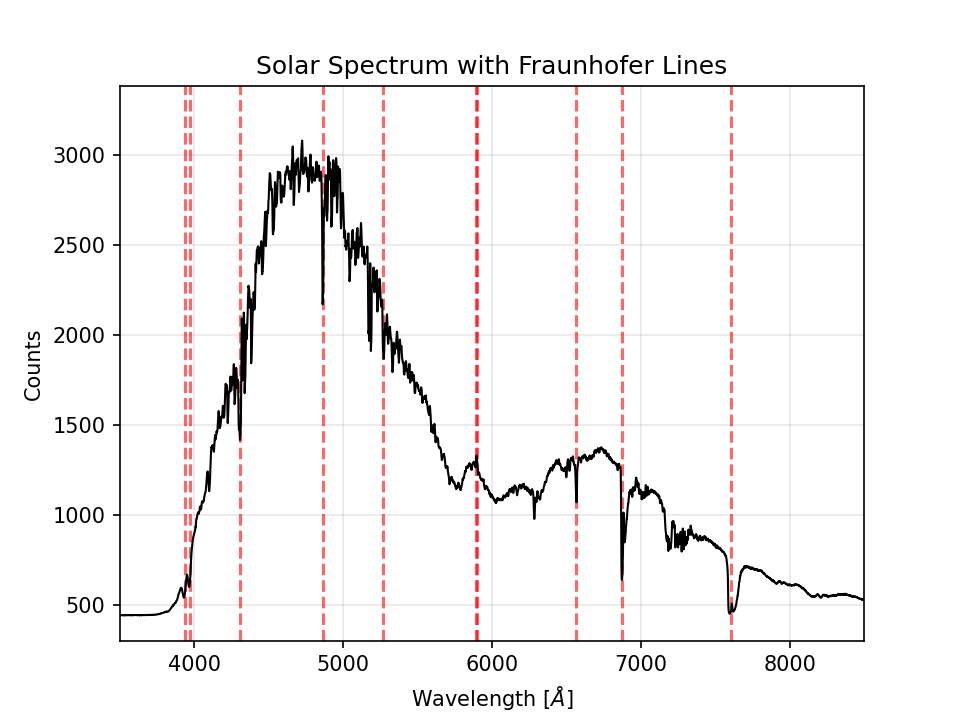

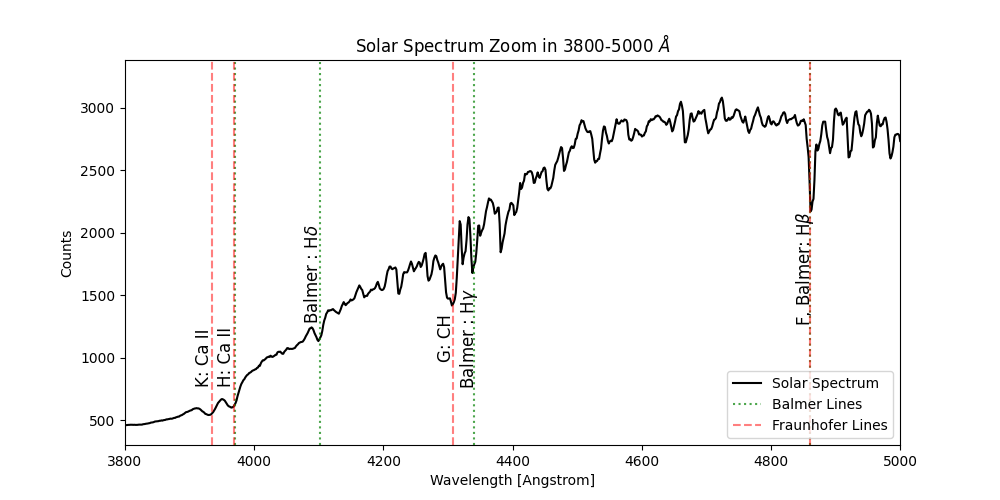

In [117]:
# wavecal spectrum using waveline solution from He
wl_solar = m_wavecal_He * x_pix_solar + b_wavecal_He
peaks_wl_solar = m_wavecal_He * strong_peaks_solar + b_wavecal_He
plot_spec_and_peaks(wl_solar, spec_solar, strong_peaks_idx=strong_peaks_solar_idx, 
                    title="Solar Spectrum with Fraunhofer Lines", xmin=3500, xmax=8500,
                    xlabel=r"Wavelength [$\AA$]", ylabel="Counts", plot_reflines=fraunhofer)
# label most important Fraunhofer lines
plt.text(7607.5-150, 950, r'A: O2 $\oplus$', rotation=90, color='k', fontsize=8)
plt.text(6875.5-150, 1500, r'B: O2 $\oplus$', rotation=90, color='k', fontsize=8)
plt.text(6563-100, 1500, r'C: H$\alpha$', rotation=90, color='k', fontsize=8)
plt.text(5893-150, 1400, r'$\text{D}_{1,2}$: Na I', rotation=90, color='k', fontsize=8)
plt.text(5270-100, 1500, 'E: Fe I', rotation=90, color='k', fontsize=8)
plt.text(4861-100, 1900, r'F: H$\beta$', rotation=90, color='k', fontsize=8)
plt.text(4308-100, 1200, 'G: CH', rotation=90, color='k', fontsize=8)
plt.text(3934-100, 1000, 'H, K: Ca II', rotation=90, color='k', fontsize=8)

# also plot a zoom in on Balmer lines
plt.figure(figsize=(10, 5))
plt.plot(wl_solar, spec_solar, label='Solar Spectrum', color='black')
plt.xlabel('Wavelength [Angstrom]')
plt.ylabel('Counts')
plt.title(r'Solar Spectrum Zoom in 3800-5000 $\AA$')
plt.xlim([3800, 5000])
for balmer_line in balmer:
    if balmer_line > 3900:
        plt.axvline(x=balmer_line, color='green', linestyle=':', alpha=0.7,
                    label ='Balmer Lines' if balmer_line == balmer[0] else "")
for fh_line in fraunhofer:
    plt.axvline(x=fh_line, color='red', linestyle='--', alpha=0.5,
                label ='Fraunhofer Lines' if fh_line == fraunhofer[0] else "")
plt.text(4861-25, 1300, r'F, Balmer: H$\beta$', rotation=90, color='k', fontsize=12)
plt.text(4308-25, 1000, 'G: CH', rotation=90, color='k', fontsize=12)
plt.text(3934-25, 800, 'K: Ca II', rotation=90, color='k', fontsize=12)
plt.text(3968-25, 800, 'H: Ca II', rotation=90, color='k', fontsize=12)
# label balmer lines
plt.text(4340.47-25, 800, r'Balmer : H$\gamma$', rotation=90, color='k', fontsize=12)
plt.text(4101.74-25, 1300, r'Balmer : H$\delta$', rotation=90, color='k', fontsize=12)
plt.legend()

<img src="G_spectrum_atlas.png" width="65%">

## Comparing the Atlas and our Solar Spectrum, we can determine the spectral type:
Features of our observed spectrum:
 - some balmer lines (~4100, 4350, 4850) visible but not strong
 - Strong Ca II, CH, H beta and alpha, Na I 
This suggests G-type star of some kind

We can narrow down even further by comparing the 3 different G-dwarf spectra from the screenshot of the stellar spectral atlas above. The main giveaway is the Balmer lines, which become more pronounced as one goes down from earlier to later types. Also, the Ca II lines get more prononunced as one moves to later types, but they are relatively shallow here, suggesting that this is an earlier type (G0-G5) sepctrum. This makes sense, as the sun's spectral type is known to be G2. Our observed spectrum corresponds with expectation.

# Nova Doppler Shift

/var/folders/tt/88v84jmx60l0rhhpfn6sl9nh0000gp/T/ipykernel_18151/3340328728.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,5))


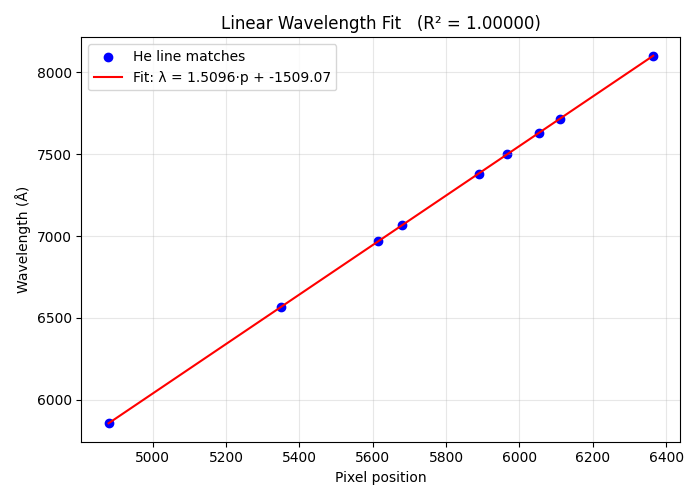

In [190]:
# solve for wavelength solution using NeAr lines from that obs
wl_cal_pcyg_near_fname = os.path.join(wl_cals_dir, 'ne_ar_cal_15s_exp24.fit')
imNeAr_pcyg = fits.getdata(wl_cal_pcyg_near_fname)[2000:4000, :]
xpix_near, spec_1d_near = extract_1d_spec(imNeAr_pcyg, y_min=1000, y_max=2000)
strong_peaks_near, strong_peaks_near_idx = my_find_peaks(spec_1d_near, prominence=1000, distance=10, num_peaks=10)

# make array of strong peak indices that corresponds to the peaks from ne_ar_wls
peak_indices_near_pcyg = np.array([4880, 5350, 5614, 5681, 5889, 5967, 6053, 6111, 6365])
ne_ar_wls_pcyg = np.array([5857.49403984, 6566.7529648, 6966.65427355, 7067.76139689,
                            7380.13713618, 7499.35299803, 7629.13229069, 7716.6578601, 8098.45043039])

m_wavecal_pcyg, b_wavecal_pcyg, r2_pcyg = fit_linear_wavelength(peak_indices_near_pcyg, ne_ar_wls_pcyg)
wl_near_pcyg = m_wavecal_pcyg * xpix_near + b_wavecal_pcyg

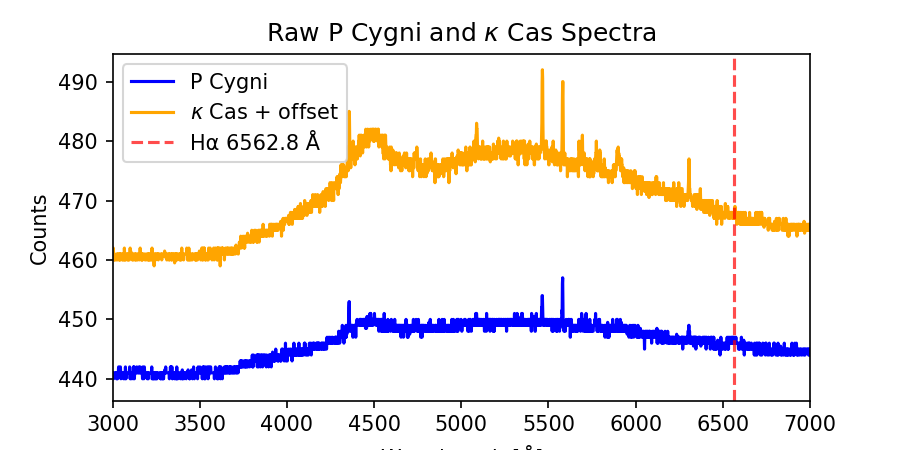

In [201]:
# load in and inspect P Cygni spectra
imPCyg = fits.getdata(p_cyg_fname_2)[2000:4000, :]
imKCas = fits.getdata(kap_cas_fname)[2000:4000, :]

# inspect uncalibrated P Cygni and Kappa Cas spectra
x_pix_pcyg, spec_pcyg = extract_1d_spec(imPCyg, y_min=1000, y_max=1500)
x_pix_kcas, spec_kcas = extract_1d_spec(imKCas, y_min=1350, y_max=1700)

# apply wavelength calibration from He lamp
wl_pcyg = m_wavecal_pcyg * x_pix_pcyg + b_wavecal_pcyg
wl_kcas = m_wavecal_pcyg * x_pix_kcas + b_wavecal_pcyg

# plot P Cygni spectrum and Kappa Cas spectrum on same plot
plt.figure(figsize=(6,3), dpi=150)
plt.plot(wl_pcyg, spec_pcyg, label='P Cygni', color='blue')
plt.plot(wl_kcas, spec_kcas+20, label=r'$\kappa$ Cas + offset', color='orange')
plt.xlim([3000, 7000])
plt.axvline(6562.8, color='red', linestyle='--', alpha=0.7, label='Hα 6562.8 Å')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Counts')
plt.title(r'Raw P Cygni and $\kappa$ Cas Spectra')
plt.legend()

It's clear that we won't be able to see the P Cygni profile from the raw spectrum, we'll actually have to reduce the spectrum, taking the following steps:
 - crop the spectrum from the 2D image
 - detect the trace center 
 - perform sky subtraction
 - apply wavelength solution
 - normalize the continuum

## P Cygni first:

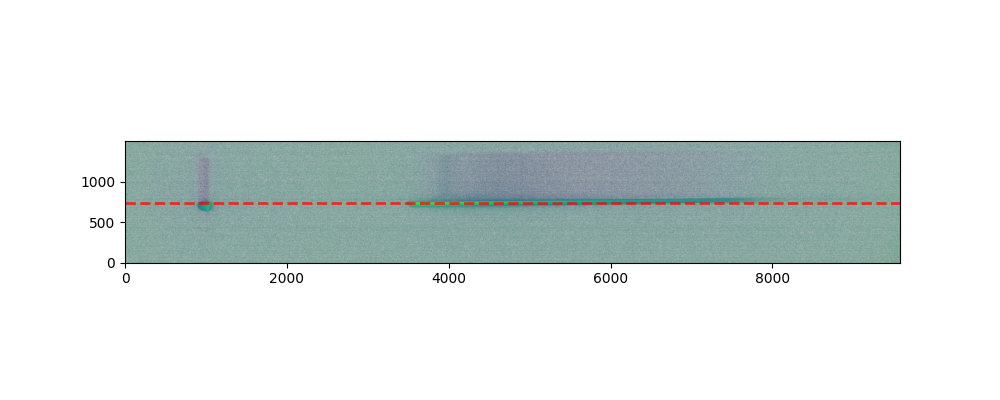

spectra y center in crop at pixel: 739.818
sigma width of gaussian fit in pixels: 14.029


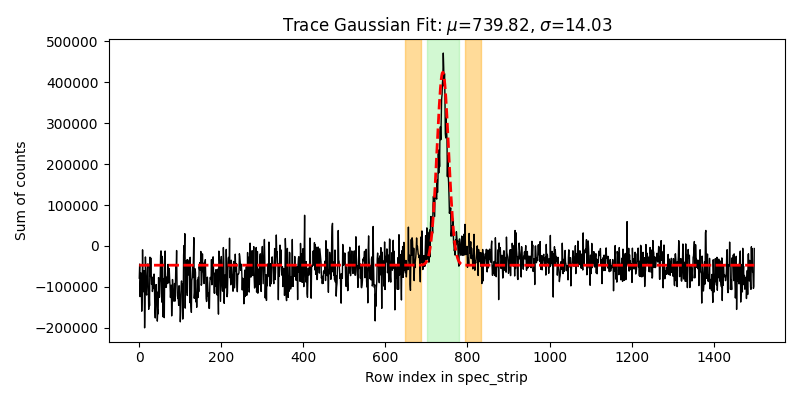

/var/folders/tt/88v84jmx60l0rhhpfn6sl9nh0000gp/T/ipykernel_18151/898593219.py:22: RuntimeWarning: divide by zero encountered in divide
  flux_norm = spec_1d / cont_pcyg


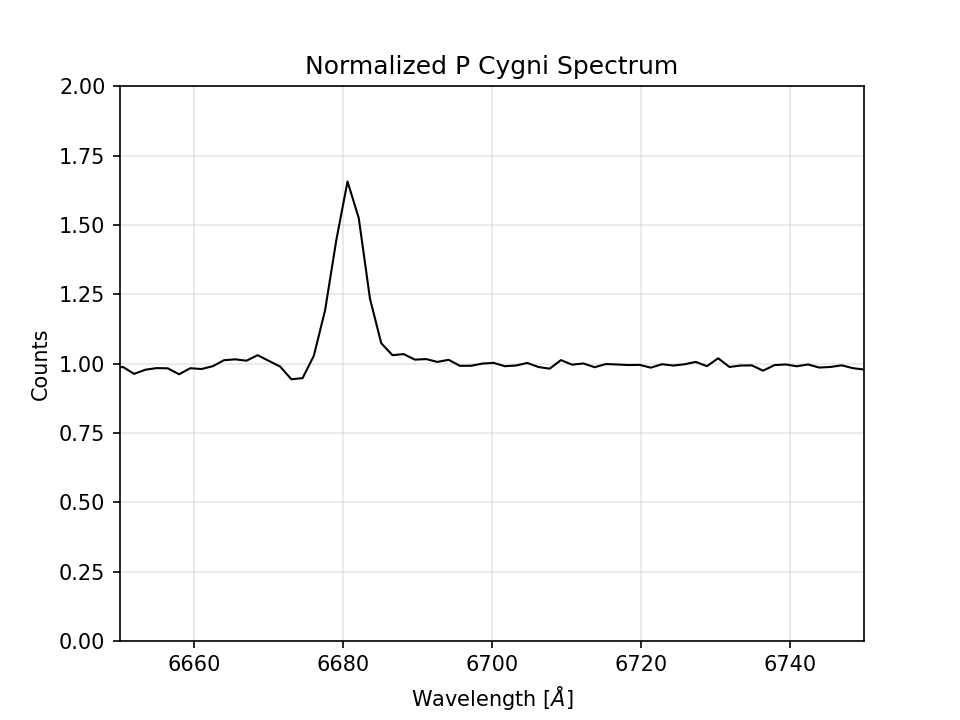

/var/folders/tt/88v84jmx60l0rhhpfn6sl9nh0000gp/T/ipykernel_18151/898593219.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


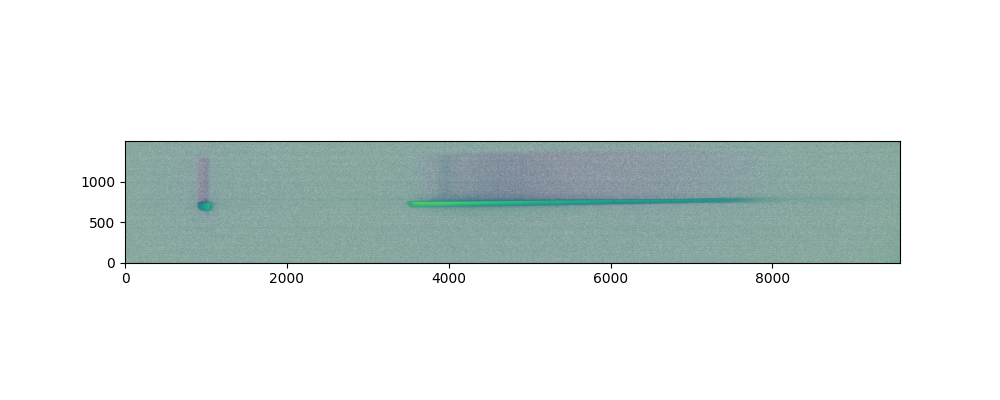

In [301]:
# crop around just P Cygni
path = p_cyg_fname_1
caldata, hdr = calibrate_science_frame(path, master_bias, master_dark, master_flat)
crop = crop_spectrum_region(caldata, center_row = 3250, height=1500)

# find trace center and width of sepctrum
y_trace, sigma = detect_trace_center(crop)
spec_2d = isolate_spectrum(crop, y_trace, sigma)
spec_1d = np.sum(spec_2d, axis=0)

# inspect trace fit and spectrum
print(f'spectra y center in crop at pixel: {y_trace:.3f}')
print(f'sigma width of gaussian fit in pixels: {sigma:.3f}')
inspect_trace_fit(crop, y_trace, sigma)

# apply wavelength solution
x_pix_pcyg = np.arange(spec_1d.size)
wl_pcyg = m_wavecal_pcyg * x_pix_pcyg + b_wavecal_pcyg

# fit continuum and normalize
cont_pcyg, spec_pcyg_norm = continuum_running_median(wl_pcyg, spec_1d, width=1000, unit="angstrom")
flux_norm = spec_1d / cont_pcyg

So it's clear that even in our reduced and calibrated P Cygni spectra, there is no P Cygni profile anywhere, which highly unfortunate. We will probably have to look at Group 3's data if this is the case.

## Now $\kappa$ Cas:

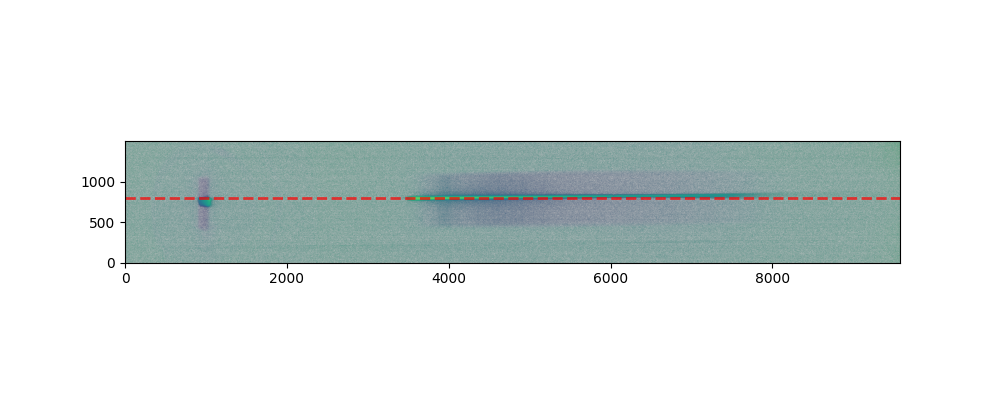

spectra y center in crop at pixel: 800.061
sigma width of gaussian fit in pixels: 8.625


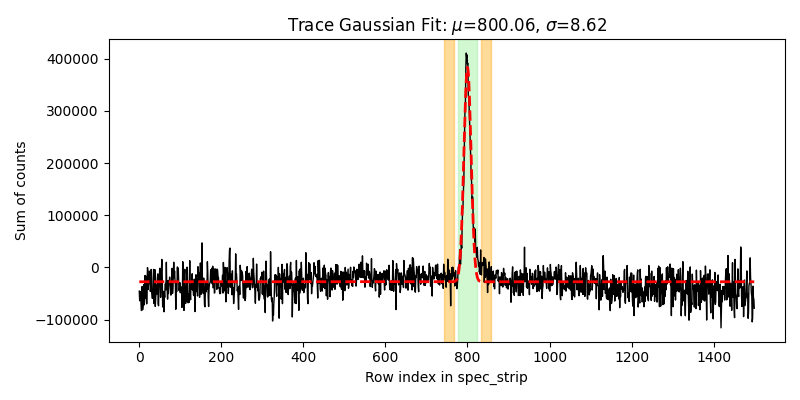

/var/folders/tt/88v84jmx60l0rhhpfn6sl9nh0000gp/T/ipykernel_18151/1994441202.py:22: RuntimeWarning: divide by zero encountered in divide
  flux_norm_kcas = spec_1d_kcas / cont_kcas


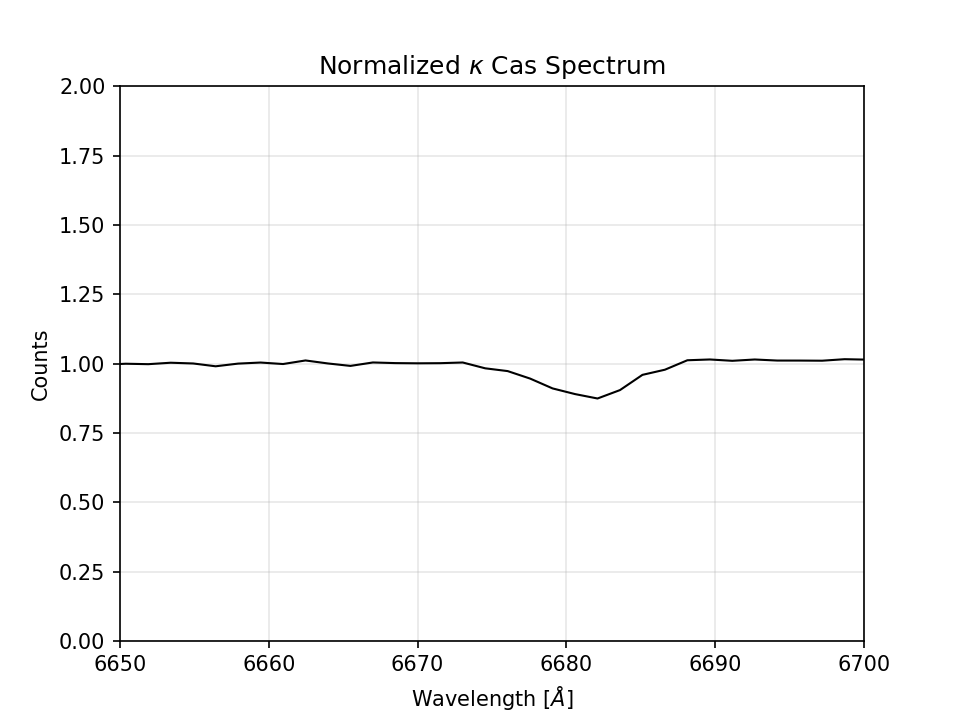

/var/folders/tt/88v84jmx60l0rhhpfn6sl9nh0000gp/T/ipykernel_18151/1994441202.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


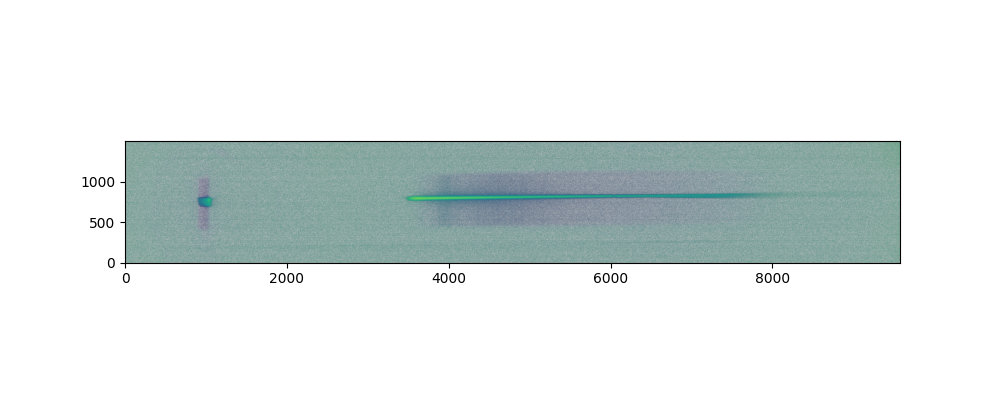

In [296]:
# crop around just P Cygni
path = kap_cas_fname
caldata, hdr = calibrate_science_frame(path, master_bias, master_dark, master_flat)
crop = crop_spectrum_region(caldata, center_row = 3500, height=1500)

# find trace center and width of sepctrum
y_trace, sigma = detect_trace_center(crop)
spec_2d = isolate_spectrum(crop, y_trace, sigma)
spec_1d_kcas = np.sum(spec_2d, axis=0)

# inspect trace fit and spectrum
print(f'spectra y center in crop at pixel: {y_trace:.3f}')
print(f'sigma width of gaussian fit in pixels: {sigma:.3f}')
inspect_trace_fit(crop, y_trace, sigma)

# apply wavelength solution
x_pix_kcas = np.arange(spec_1d_kcas.size)
wl_kcas = m_wavecal_pcyg * x_pix_kcas + b_wavecal_pcyg

# fit continuum and normalize
cont_kcas, spec_kcas_norm = continuum_running_median(wl_kcas, spec_1d_kcas, width=1000, unit="angstrom")
flux_norm_kcas = spec_1d_kcas / cont_kcas
plot_spec_and_peaks(wl_kcas, flux_norm_kcas, title=r"Normalized $\kappa$ Cas Spectrum", 
                    xlabel=r"Wavelength [$\AA$]", ylabel="Counts", xmin=6650, xmax=6700, ymax=2)
plt.legend()

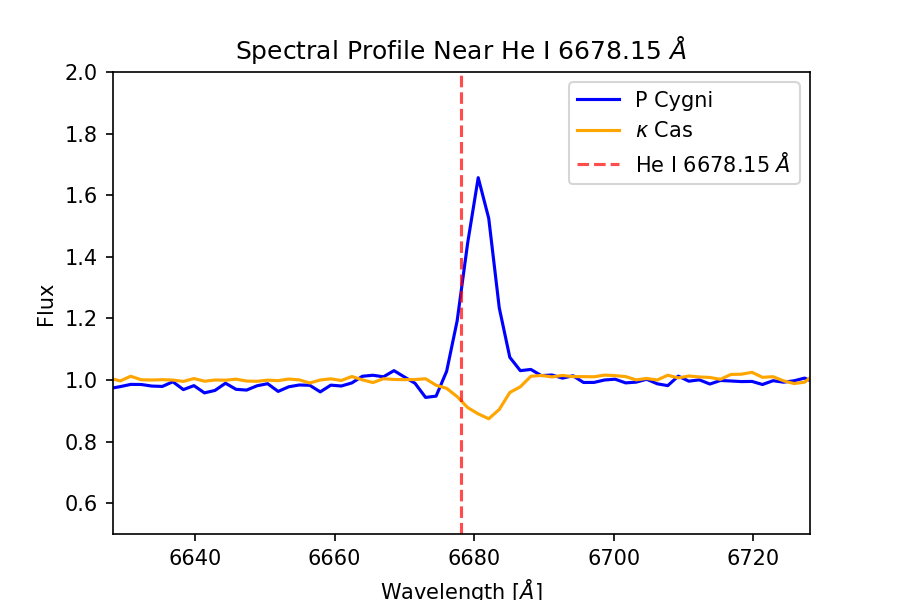

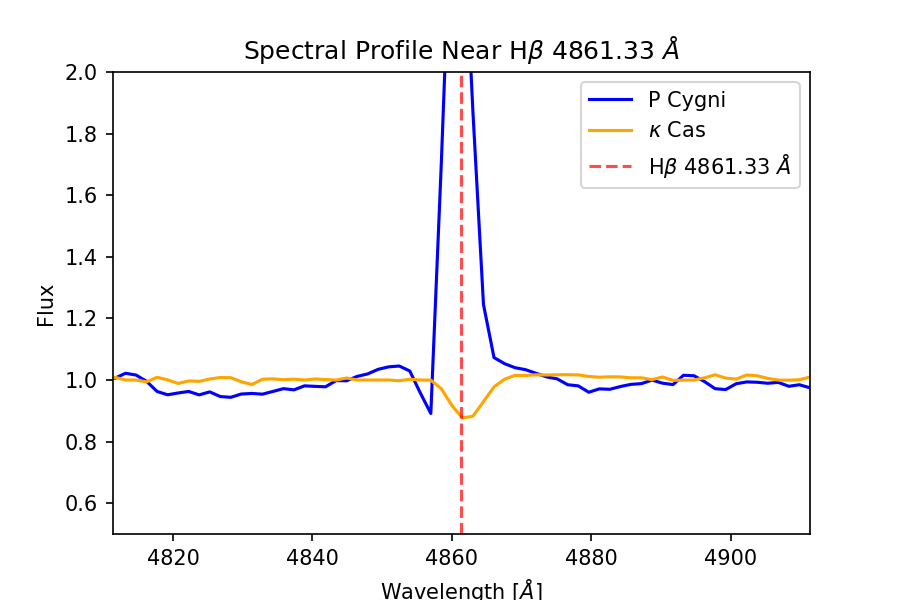

In [310]:
# plot the P Cygni and Kappa Cas spectra to compare the P Cygni profile vs not, where visible
lines_where_pcyg = [6678.15, 4861.33]  # He I, H beta
line_names_where_pcyg = [r'He I 6678.15 $\AA$', r'H$\beta$ 4861.33 $\AA$']
# make a figure for each line of interest
for line, name in zip(lines_where_pcyg, line_names_where_pcyg):
    plt.figure(figsize=(6,4), dpi=150)
    plt.plot(wl_pcyg, flux_norm, label='P Cygni', color='blue')
    plt.plot(wl_kcas, flux_norm_kcas, label=r'$\kappa$ Cas', color='orange')
    plt.axvline(line, color='red', linestyle='--', alpha=0.7, label=name)
    plt.xlim([line-50, line+50])
    plt.ylim([0.5, 2])
    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel('Flux')
    plt.title(f'Spectral Profile Near {name}')
    plt.legend()